This paper argues that memorization is a behavior exhibited by networks trained on random data, as, in the absence of patterns, they can only rely on remembering examples. The authors investigate this phenomenon and make three key claims:

1. Networks do not exclusively memorize data.
2. Networks initially learn simple patterns before resorting to memorization.
2. Regularization prevents memorization and promotes generalization.

Here we aim to reproduce Figures 1, 7, and 8 from the paper.

## Fig 1

To support the first claim, the authors argue if networks simply memorize inputs they perform equally when on different training examples. However, if networks learn patterns, there should be points that are easy to learn because they fit these patterns better than others. To see if this is the case they train an MLP for a single epoch starting from 100 different initializations and data shufflings and log the percentage of times an example was correctly classified.

The experiment is performed with the CIFAR10 dataset, a noisy input version *RandX*, and a noisy label version *RandY*. We first define dataset wrappers to implement the noisy variants. Note that for epoch-to-epoch consistency we determine which examples to corrupt at initialization.

In [1]:
#| code-summary: Imports and model evaluation function
#| output: false
#| echo: false

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torchvision import datasets, transforms, models, utils 
from torch.utils.data import DataLoader, Dataset
from PIL import Image

import numpy as np
import pandas as pd
import os, functools, itertools
try:
    import seaborn as sns
    import matplotlib.pyplot as plt
except: pass

os.makedirs('logs', exist_ok = True)
os.makedirs('models', exist_ok = True)


device = torch.device(
    'cuda' if torch.cuda.is_available() else
    ('mps' if torch.backends.mps.is_available() else
    'cpu')
)

def set_seed(seed = 42):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if device.type == 'cuda':
        print('Setting seed for CUDA')
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
set_seed()

def eval_model(model, test, criterion = nn.CrossEntropyLoss()):
    model.to(device); model.eval()
    correct, loss = 0, 0.0
    with torch.no_grad():
        for images, labels in test:
            images, labels = images.to(device), labels.to(device)
            _, pred = torch.max(model(images), 1)
            correct += (pred == labels).float().sum().item()
            loss += criterion(model(images), labels).item()
    return loss / len(test.dataset), correct / len(test.dataset)

device

device(type='mps')

In [264]:
#| code-summary: CIFAR-10 dataset
#| output: false
#| echo: false
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]
)
train_set = datasets.CIFAR10('../data', download = True, train = True, transform = transform)
test_set = datasets.CIFAR10('../data', download = True, train = False, transform = transform)
n_classes = len(train_set.classes)

Files already downloaded and verified
Files already downloaded and verified


In [265]:
#| code-summary: Random dataset wrappers
class RandX(Dataset):
    """Injects example noise into dataset by replacing x% of inputs with random gaussian N(0, 1) noise"""
    def __init__(self, dataset, x = 1.0):
        self.dataset = dataset
        self.x = x

        self.modified = {}
        for idx, (img, _) in enumerate(self.dataset):
            if np.random.rand() <= x:
                self.modified[idx] = torch.randn_like(img)
        torch.save(self.modified, os.path.join(dataset.root, 'randX_modified'))

    def __len__(self): return len(self.dataset)

    def __getitem__(self, idx):
        X, y = self.dataset[idx]
        return self.modified.get(idx, X), y 

class RandY(Dataset):
    """Injects example noise into dataset by replacing y% of labels with random labels"""
    def __init__(self, dataset, y = 1.0):
        self.dataset = dataset
        self.y = y

        self.modified = {}
        for idx in range(len(self.dataset)):
            if np.random.rand() <= y:
                self.modified[idx] = np.random.randint(0, len(self.dataset.classes))
        torch.save(self.modified, os.path.join(dataset.root, 'randY_modified'))

    def __len__(self): return len(self.dataset)

    def __getitem__(self, idx):
        X, y = self.dataset[idx]
        return X, self.modified.get(idx, y)

Now we define a standard training loop, initialization functions, and the MLP specified in the paper.

In [8]:
#| code-summary: Model initing and training functions
def train(model, train, val, optimizer, criterion = nn.CrossEntropyLoss(), epochs = 100, batch_size = 256, save_path = 'models/tmp'):
    model.to(device)
    train = DataLoader(train, batch_size = batch_size, shuffle = True)
    val = DataLoader(val, batch_size = batch_size, shuffle = False)
    best_loss = np.inf
    for epoch in range(epochs):
        model.train()
        for images, labels in train:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            loss = criterion(model(images), labels)
            loss.backward()
            optimizer.step()
        val_loss, val_acc = eval_model(model, val)
        if val_loss < best_loss:
            best_loss = val_loss
            torch.save(model.state_dict(), save_path)
        print(f'Epoch {epoch + 1}/{epochs}, Loss: {val_loss:.4f}, Accuracy: {val_acc:.4f}')

def _init_weights(m):
    if 'Linear' in str(type(m)):
        nn.init.xavier_uniform_(m.weight)
        nn.init.zeros_(m.bias)
    elif isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
    elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
        nn.init.constant_(m.weight, 1)
        nn.init.constant_(m.bias, 0)

def initialize_model(model, data_loader, in_device = False):
    with torch.no_grad():
        imgs, _ = next(iter(data_loader))
        if in_device:model.to(device); model(imgs.to(device))
        _ = model(imgs)
        model.apply(_init_weights)

In [248]:
#| code-summary: MLP definition
class MLP(nn.Module):
    def __init__(self, n_classes = 10):
        super().__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.LazyLinear(4096),
            nn.ReLU(),
            nn.LazyLinear(4096),
            nn.ReLU(),
            nn.LazyLinear(n_classes)
        )

    def forward(self, x):
        return self.model(x)

And run the experiment, training models for a single epoch as in the paper but also after 10 epochs to investigate how results vary.

In [ ]:
#| code-summary: Get estimated P(correct)
#| output: false
def add_missclassified(missclassified, model, test_set, batch_size = 256):
    model = model.to(device); model.eval()
    test = DataLoader(test_set, batch_size = batch_size, shuffle = False)
    i = 0
    with torch.no_grad():
        for images, labels in test:
            images, labels = images.to(device), labels.to(device)
            _, pred = torch.max(model(images), 1)
            missclassified[i:i + test.batch_size] += (pred != labels).float()
            i += test.batch_size

def gen_fig_1(epochs = 1, n_inits = 100):
    training_sets = [train_set, RandX(train_set, x = 1.0), RandY(train_set, y = 1.0)]
    for training_set in training_sets:
        missclassified = torch.zeros(len(test_set)).to(device)
        for _ in range(n_inits):
            m = MLP()
            initialize_model(m, DataLoader(train_set, batch_size = 256))
            train(m, training_set, test_set, optim.SGD(m.parameters(), lr = 0.01), epochs = epochs)
            add_missclassified(missclassified, m, test_set)
        missclassified /= n_inits
        torch.save(missclassified, f'logs/missclassified_epochs={epochs}_' + training_set.__class__.__name__)

gen_fig_1(epochs = 1, n_inits = 100)
gen_fig_1(epochs = 10, n_inits = 100)

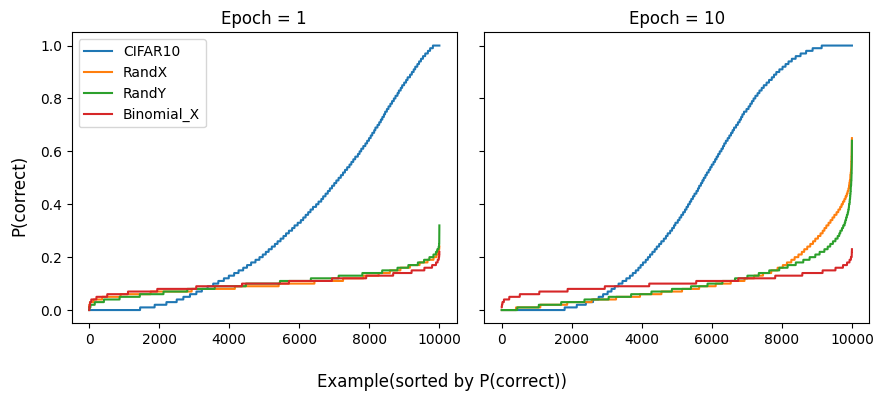

In [249]:
#| code-summary: Plot results
f, (ax1, ax2) = plt.subplots(1, 2, figsize = (9, 4), sharey = True)

for ax, epochs in zip([ax1, ax2], [1, 10]):

    for fname in sorted([f for f in os.listdir('logs') if 'missclassified' in f and f'epochs={epochs}_' in f]):
        missclassified = torch.load(os.path.join('logs', fname))
        p = (1 - missclassified).sort().values.to('cpu').numpy()
        ax.plot(p, label = fname.split('_')[-1])
    
    # Plot binomially sampled points
    randX_mean = 1 - torch.load(os.path.join('logs', 'missclassified_RandX')).mean().item()
    bin_data = np.random.binomial(n = 100, p = randX_mean, size = 10000) / 100
    bin_data.sort()
    ax.plot(bin_data, label = 'Binomial_X')
    ax.set_title(f'Epoch = {epochs}')

ax1.legend()
f.supylabel('P(correct)')
f.supxlabel('Example(sorted by P(correct))')
f.tight_layout()

Observe that the left is a figure very similar to the paper's. Whereas real data has easy patterns that can be learned in a single epoch, random data does not and networks must resort to memorization. After 10 epochs we observe that the networks trained on random data manage to improve the performance on a few points at the expense of the rest, whose performance becomes worse than random.

Out of curiosity here are the 10 easiest and hardest examples.

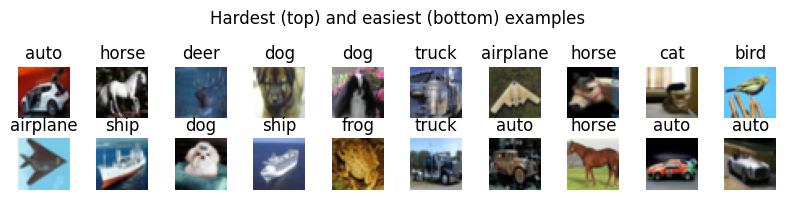

In [199]:
#| code-summary: Plot hardest and easiest examples
n = 10
f, ax = plt.subplots(2, n, figsize = (n - 2, 2))
for i, idx in enumerate(torch.sort(p).indices[:n]):
    img, label = test_set[idx]
    ax[0][i].imshow(img.permute(1, 2, 0).numpy())
    ax[0][i].axis('off')
    ax[0][i].set_title(test_set.classes[label].replace('mobile', ''))

for i, idx in enumerate(torch.sort(p).indices[-n:]):
    img, label = test_set[idx]
    ax[1][i].imshow(img.permute(1, 2, 0).numpy())
    ax[1][i].axis('off')
    ax[1][i].set_title(test_set.classes[label].replace('mobile', ''))

f.suptitle('Hardest (top) and easiest (bottom) examples')
f.tight_layout()

## Fig 2

The fact that networks learn patterns when trained on real data and don't when trained on noise can also be visualized by plotting the first layer weights of a convolutional network. We show the weights for networks trained for 10 epochs on real and random data.

In [4]:
#| code-summary: ConvNet definition
class ConvNet(nn.Module):
    def __init__(self, num_classes):
        super(ConvNet, self).__init__()

        self.model = nn.Sequential(
            nn.LazyConv2d(out_channels=200, kernel_size=5),  # LazyConv2d to infer input channels
            nn.BatchNorm2d(200),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=3),

            nn.LazyConv2d(out_channels=200, kernel_size=5),  # Another LazyConv2d
            nn.BatchNorm2d(200),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=3),

            nn.Flatten(),  # Flatten for the fully connected layer
            nn.LazyLinear(out_features=384),  # LazyLinear to infer input features
            nn.BatchNorm1d(384),
            nn.ReLU(),

            nn.LazyLinear(out_features=192),  # Another LazyLinear
            nn.BatchNorm1d(192),
            nn.ReLU(),

            nn.LazyLinear(out_features=num_classes)
        )

    def forward(self, x):
        return self.model(x)
    
def train_conv(model, train, val, optimizer, criterion = nn.CrossEntropyLoss(), epochs = 100, batch_size = 256):
    model.to(device)
    train = DataLoader(train, batch_size = batch_size, shuffle = True)
    val = DataLoader(val, batch_size = batch_size, shuffle = False)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size = 15, gamma = 0.5)
    for epoch in range(epochs):
        model.train()
        for images, labels in train:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            loss = criterion(model(images), labels)
            loss.backward()
            optimizer.step()
        scheduler.step()
        val_loss, val_acc = eval_model(model, val)
        print(f'Epoch {epoch + 1}/{epochs}, Loss: {val_loss:.4f}, Accuracy: {val_acc:.4f}')

In [165]:
#| code-summary: Train models
#| output: false
cifar10_model = ConvNet(num_classes = n_classes)
randY_model = ConvNet(num_classes = n_classes)

for model, dataset in zip([cifar10_model, randY_model], [train_set, RandY(train_set)]):
    initialize_model(model, DataLoader(dataset, batch_size = 256))
    train_conv(model, dataset, test_set, optim.SGD(model.parameters(), lr = 0.01, momentum = 0.9), epochs = 10)
    torch.save(model.state_dict(), f'models/fig2_{model.__class__.__name__}')

/Users/emiliocantucervini/Library/Python/3.9/lib/python/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Epoch 1/10, Loss: 0.0066, Accuracy: 0.4529
Epoch 2/10, Loss: 0.0049, Accuracy: 0.5640
Epoch 3/10, Loss: 0.0055, Accuracy: 0.5337
Epoch 4/10, Loss: 0.0045, Accuracy: 0.6203
Epoch 5/10, Loss: 0.0041, Accuracy: 0.6488
Epoch 6/10, Loss: 0.0043, Accuracy: 0.6323
Epoch 7/10, Loss: 0.0049, Accuracy: 0.6006
Epoch 8/10, Loss: 0.0096, Accuracy: 0.4231
Epoch 9/10, Loss: 0.0051, Accuracy: 0.6301
Epoch 10/10, Loss: 0.0050, Accuracy: 0.6260
Epoch 1/10, Loss: 0.0093, Accuracy: 0.0996
Epoch 2/10, Loss: 0.0093, Accuracy: 0.1094
Epoch 3/10, Loss: 0.0094, Accuracy: 0.0905
Epoch 4/10, Loss: 0.0093, Accuracy: 0.1027
Epoch 5/10, Loss: 0.0095, Accuracy: 0.0919
Epoch 6/10, Loss: 0.0094, Accuracy: 0.1187
Epoch 7/10, Loss: 0.0094, Accuracy: 0.0937
Epoch 8/10, Loss: 0.0094, Accuracy: 0.1026
Epoch 9/10, Loss: 0.0096, Accuracy: 0.1060
Epoch 10/10, Loss: 0.0097, Accuracy: 0.1082


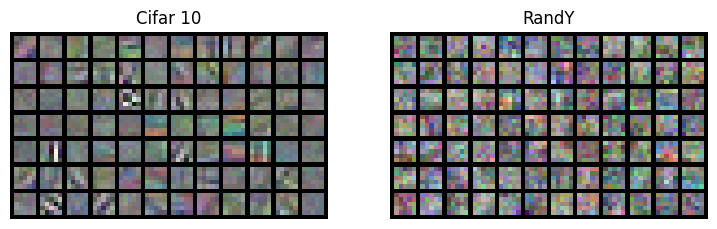

In [182]:
#| code-summary: Plot filters
f, (ax1, ax2) = plt.subplots(1, 2, figsize = (9, 4), sharey = True)

for name, model, ax in zip(['Cifar 10', 'RandY'], [cifar10_model, randY_model], [ax1, ax2]):

    model.eval()
    kernel_weights = model.model[0].weight[:7 * 12].detach().cpu().clone()
    kernel_weights = (kernel_weights - kernel_weights.min()) / (kernel_weights.max() - kernel_weights.min())
    filter_img = utils.make_grid(kernel_weights, nrow = 12, padding = 1)
    ax.imshow(filter_img.permute(1, 2, 0))
    ax.set_title(name)
    ax.axis('off')

And we are able to see that the filters learned by the network trained on real data are much more structured and seem useful in contrast to the ones learned by training on noise.

## Fig 9

To attempt to show that networks trained on real data are simpler hypotheses because they learn patterns, the authors introduce *Critical Sample Ratio* as a way to measure complexity. The idea is to

>"estimate the complexity by measuring how
densely points on the data manifold are present around the
model’s decision boundaries. Intuitively, if we were to randomly sample points from the data distribution, a smaller
fraction of points in the proximity of a decision boundary
suggests that the learned hypothesis is simpler."

A simple sketch illustrates:


![CSR intuition sketch](index_files/images/fig9_sketch.jpg){width=300 fig-align="center"}

To estimate the density of points close to decision boundaries we might perturb the original data points within a box of size $r$ and see if we cross the boundary. If a point crosses a boundary we call it "critical". The *Critical Sample Ratio* is then the proportion of points that are critical and we expect simpler networks to have lower CSRs.

The perturbation done to data points is not totally random. The technique used by the paper is presented in Algorithm 1, borrows ideas from adversarial attacks, and is called Langevin Adversarial Sample Search (LASS). Here is how I implemented it.

In [195]:
#| code-summary: LASS implementation
def standard_normal(shape):
    r = torch.randn(shape)
    r = r.to(device)
    return r

def lass(model, x, alpha = 0.25 / 255, beta = 0.2 / 255, r = 0.3 / 255, eta = standard_normal, max_iter = 10):
    """
    Langevin Adversarial Sample Search (LASS).
    Finds a perturbation of x that changes the model's prediction.
    
        labels: Tensor of true labels corresponding to the input x.
        alpha: Step size for the gradient sign method.
        beta: Scaling factor for the noise.
        r: Clipping radius for adversarial perturbations.
        eta: Noise process.
    """
    # Orignal prediction
    with torch.no_grad():
        pred_on_x = model(x).argmax(dim=1)
    

    x_adv = x.clone().detach().requires_grad_(True)
    converged = False
    iter_count = 0

    while not converged and iter_count < max_iter:
        iter_count += 1

        # Forward pass to get model output
        x_adv.requires_grad_(True)
        output = model(x_adv)

        # Compute gradient of the output with respect to input
        loss = F.cross_entropy(output, pred_on_x)  # Use actual labels
        loss.backward()

        # Compute the perturbation
        gradient_sign = x_adv.grad.sign()
        delta = alpha * gradient_sign + beta * eta(x_adv.shape)

        with torch.no_grad():
            
            x_adv += delta

            # Apply the clipping to each dimension so that each pixel is in the range [x - r, x + r]
            x_adv = torch.clamp(x_adv, x - r, x + r)

            # Check if the adversarial example has changed the model's prediction
            new_output = model(x_adv)
            if not torch.equal(output.argmax(dim=1), new_output.argmax(dim=1)):
                converged = True
                x_hat = x_adv.clone().detach()

        # Zero the gradients for the next iteration
        model.zero_grad()
        if x_adv.grad is not None: x_adv.grad.zero_()

    return converged, x_hat if converged else None

def compute_csr(model, test_set, n_examples = None, shuffle = False, **lass_kwargs):
    if n_examples is None: n_examples = len(test_set)
    model = model.to(device)
    csr = 0
    for i, (images, labels) in enumerate(DataLoader(test_set, batch_size = 1, shuffle = shuffle)):
        if i == n_examples: break
        images, labels = images.to(device), labels.to(device)
        converged, _ = lass(model, images, **lass_kwargs)
        if converged: csr += 1
    return csr / n_examples

The paper sets the radius we search for adversarial examples to $r = 30/255$ because it was small enough to not be noticed by a human evaluator. Here is an example.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


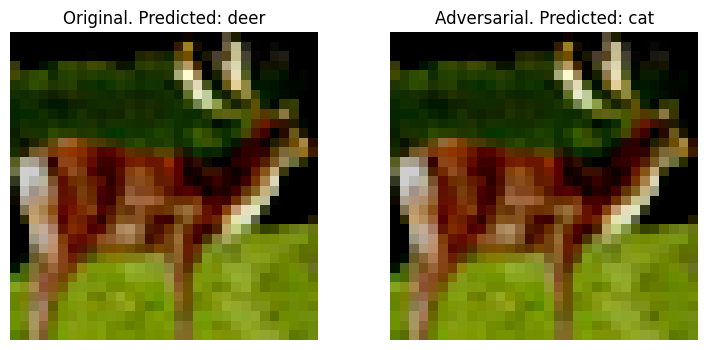

In [335]:
#| code-summary: Adversarial example
model = cifar10_model
model.eval(); model.to(device)
set_seed(5)

f, (ax1, ax2) = plt.subplots(1, 2, figsize = (9, 4), sharey = True)
for i, (x, y) in enumerate(DataLoader(test_set, batch_size = 1, shuffle = True)):
    x = x.to(device)
    y = y.to(device)
    with torch.no_grad():
        if model(x).argmax() != y: continue
    converged, adv = lass(model, x)
    if converged:
        ax1.imshow(x.squeeze().cpu().permute(1, 2, 0))
        ax2.imshow(adv.squeeze().cpu().permute(1, 2, 0))
        ax1.axis('off'); ax2.axis('off')
        with torch.no_grad():
            ax1.set_title(f'Original. Predicted: {test_set.classes[model(x).argmax().item()]}')
            ax2.set_title(f'Adversarial. Predicted: {test_set.classes[model(adv).argmax().item()]}')
        break

And now try to compute the Critical Sample Ratio as we train models to reproduce Figure 9.

In [ ]:
#| code-summary: ConvNet training loop
#| output: false
def train_fig9(model, train, val, optimizer, criterion = nn.CrossEntropyLoss(), epochs = 100, batch_size = 256):
    val_accs, csrs = [], []
    model.to(device)
    train = DataLoader(train, batch_size = batch_size, shuffle = True)
    val = DataLoader(val, batch_size = batch_size, shuffle = False)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size = 15, gamma = 0.5)
    for epoch in range(epochs):
        model.train()
        for images, labels in train:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            loss = criterion(model(images), labels)
            loss.backward()
            optimizer.step()
        scheduler.step()
        val_loss, val_acc = eval_model(model, val)
        val_accs.append(val_acc)
        print(f'Epoch {epoch + 1}/{epochs}, Loss: {val_loss:.4f}, Accuracy: {val_acc:.4f}')

        if epoch % 10 == 0:
            csr = compute_csr(model, val.dataset, n_examples = 500, r = 40 / 255)
            csrs.append(csr)
            print(f'CSR: {csr:.4f}')
    
    return val_accs, csrs

for dataset in [train_set, RandX(train_set, x = 1.0), RandY(train_set, y = 1.0)]:
    set_seed(seed  = 42)
    print(dataset.__class__.__name__)
    model = ConvNet(num_classes = n_classes)
    initialize_model(model, DataLoader(dataset, batch_size = 256))
    val_accs, csrs = train_fig9(model, dataset, test_set, optim.SGD(model.parameters(), lr = 0.01, momentum = 0.9), epochs = 141)
    torch.save({'val_accs': val_accs, 'csrs': csrs}, f'logs/fig9_r=45_{dataset.__class__.__name__}')

Text(0, 0.5, 'Critical Sample Ratio (CSR)')

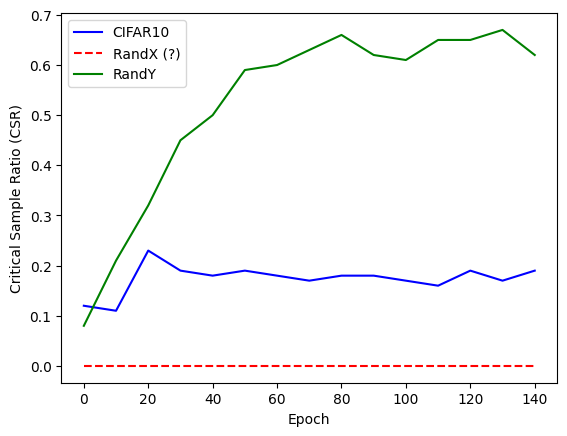

In [343]:
#| code-summary: Plot results
plt.plot(np.arange(0, 141, 10), torch.load('logs/fig9_CIFAR10')['csrs'], 'b', label = 'CIFAR10')
plt.plot(np.arange(0, 141, 10), [0] * 15, 'r--', label = 'RandX (?)')
plt.plot(np.arange(0, 141, 10), torch.load('logs/fig9_RandY')['csrs'], 'g', label = 'RandY')

plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Critical Sample Ratio (CSR)')

![Original Fig 9](index_files/images/fig9.png){width=300 fig-align="center"}

Where we observe roughly the same trend as in the paper displayed above while the network trained on real data has a somewhat constant CSR, the one trained on random labels has a higher CSR as training progresses. However, I could reproduce RandX's behavior and obtained a constant CSR of 0. I tried different seeds, $r$, and datasets (training and validation) without luck. My suspicion is that the model's capacity and thus performance were not high enough (around 10% validation accuracy). I decided to stick with the paper's architecture and move on.

## What I learned / practiced
- How to visualize 1st layer kernel weights
- A bit about adversarial attacks
- A creative proxy for model complexity (CSR)